In [1]:
import pandas as pd
df = pd.read_csv('/Users/niharikarawat/Documents/VSCODE/airbnb_price_estimator/G-featured_airbnb.csv')

In [2]:
import numpy as np
x = df.drop(['price', 'latitude', 'longitude'], axis=1)
y_log = np.log1p(df['price'])
print(x.head())
print('--' * 20)
print(y_log.head())

   number_of_reviews  availability_365  listings_per_host  \
0                187               169                  1   
1                119               300                  4   
2                275                33                  2   
3                206               180                  1   
4                 22               338                 22   

   avg_reviews_per_host  neighbourhood_freq  neighbourhood_Agoura Hills  \
0            187.000000                 305                       False   
1             59.750000                 851                       False   
2            144.000000                 788                       False   
3            206.000000                 851                       False   
4             30.227273                1519                       False   

   neighbourhood_Alhambra  neighbourhood_Altadena  neighbourhood_Arcadia  \
0                   False                   False                  False   
1                   False     

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y_log, test_size=0.2, random_state=42)

In [4]:
from xgboost import XGBRegressor
model = XGBRegressor()

In [5]:
import subprocess
import sys

try:
    from skopt import BayesSearchCV
    print("scikit-optimize is already installed!")
except ImportError:
    print("Installing scikit-optimize...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-optimize"])
    print("Installation complete!")
    from skopt import BayesSearchCV
    print("Successfully imported BayesSearchCV!")

scikit-optimize is already installed!


In [6]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
search_space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(2, 8),
    'learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'colsample_bylevel': Real(0.5, 1.0),
    'colsample_bynode': Real(0.5, 1.0),
    'reg_alpha': Real(0.0, 10.0),
    'reg_lambda': Real(0.0, 10.0),
    'gamma' : Real(0.0, 10.0)
}

opt = BayesSearchCV(model, search_space, cv=5, n_iter=30, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)

In [7]:
opt.fit(x_train, y_train)

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                             'max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [8]:
opt.best_params_

OrderedDict([('colsample_bylevel', 0.5),
             ('colsample_bynode', 0.627675892244595),
             ('colsample_bytree', 0.5681738103126582),
             ('gamma', 0.0),
             ('learning_rate', 0.14947187150908653),
             ('max_depth', 8),
             ('n_estimators', 1000),
             ('reg_alpha', 8.744117410562033),
             ('reg_lambda', 0.0),
             ('subsample', 0.5)])

In [9]:
opt.best_score_

-0.4597862143893571

In [10]:
opt.score(x_test, y_test)

-0.45373859794154275

In [11]:
opt.predict(x_test)

array([5.81046  , 5.373974 , 5.585414 , ..., 5.5249867, 5.3717422,
       6.0387073], dtype=float32)

In [12]:
print(y_test)

10210    5.517453
37613    5.231109
29194    5.135798
800      6.003887
32193    5.605802
           ...   
8161     5.093750
30693    5.624018
34284    5.141664
16809    5.802118
4475     6.885510
Name: price, Length: 7531, dtype: float64


<Figure size 1200x2000 with 0 Axes>

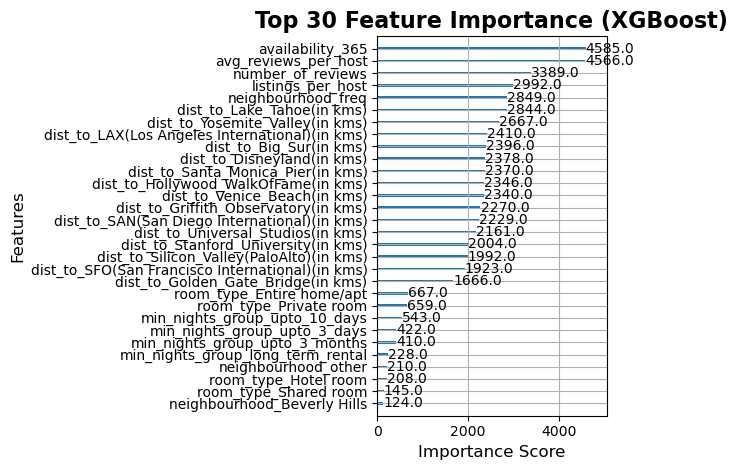

In [13]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 20))

best_model = opt.best_estimator_
plot_importance(best_model, max_num_features=30, importance_type='weight')

plt.title('Top 30 Feature Importance (XGBoost)', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

plt.tight_layout()
plt.show()

In [14]:
import pickle
with open('I-airbnb_price_estimator_model.pkl', 'wb') as f:
    pickle.dump(opt, f)